In [119]:
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../..')
from funcs.stats import get_stats
from funcs.xarray_tools import find_cor_ts
from funcs.plotting import map_grid_clean, add_text
from constants.colors import loc_colors
from funcs.plotting import plt_lc

from taus import decorrelation_temporal_model

from xrspatial import slope, aspect

In [2]:
fps = list(Path('/bsuhome/zacharykeskinen/scratch/coherence/uavsar').glob('*_tau.nc'))
dss = {fp.stem.replace('_v3_tau',''): xr.open_dataset(fp) for fp in fps}

In [5]:
def clean_two_datasets(x, y):
    x, y = x.values.ravel(), y.values.ravel()
    idx = (~np.isnan(x)) & (~np.isnan(y))
    return x[idx], y[idx]

In [117]:
trees = np.array([])
taus = np.array([])
for stem, ds in dss.items():
    print(stem)
    for heading in ds.heading:
        # t, tau = clean_two_datasets(ds['tree_perc'], decorrelation_temporal_model(12, ds['curvefit_coefficients'].sel(param = 'gamma_inf', pol = 'VV'), ds['curvefit_coefficients'].sel(param = 'tau', pol = 'VV')).sel(heading = heading))
        t, tau = clean_two_datasets(ds['tree_perc'].where(ds['land_cover'] != 11), ds['cor'].sel(pol = 'VV', heading = heading).mean('time1').mean('time2'))
        trees = np.concatenate([trees, t])
        taus = np.concatenate([taus, tau])

rockmt
alamos
grmesa
uticam
peeler
dorado
irnton
silver
fraser
lowman
stlake
sierra


In [115]:
lidar_trees = np.array([])
lidar_taus = np.array([])
for stem, ds in dss.items():
    if 'vh' not in ds.data_vars: continue
    print(stem)
    for heading in ds.heading:
        t, tau = clean_two_datasets(ds['vh'].where(ds['land_cover'] != 11), ds['cor'].sel(pol = 'VV', heading = heading).mean('time1').mean('time2'))
        lidar_trees = np.concatenate([lidar_trees, t])
        lidar_taus = np.concatenate([lidar_taus, tau])

rockmt
grmesa
silver
fraser
stlake


In [64]:
lc_dic = {'water': [11,11], 'developed': [21,24], 'forest': [41, 43], 'shrub': [51, 52], 'herbaceous': [71, 74]}
lc = {lc_class: np.array([]) for lc_class in lc_dic.keys()}
for stem, ds in dss.items():
    print(stem)
    for heading in ds.heading:
        for title, [low, upper] in lc_dic.items():
            landcover, cor = ds['land_cover'].values.ravel(), ds['cor'].sel(heading = heading, pol = 'VV').mean('time1').mean('time2').where((ds['land_cover'] >= low) & (ds['land_cover'] <= upper)).values.ravel()
            landcover_idx = (~np.isnan(landcover)) & (~np.isnan(cor))
            landcover, cor = landcover[landcover_idx], cor[landcover_idx]
            lc[title] = np.concatenate([lc[title], cor])

rockmt
alamos
grmesa
uticam
peeler
dorado
irnton
silver
fraser
lowman
stlake
sierra


In [79]:
decid = np.array([])
evergre  = np.array([])
decid_cor = np.array([])
evergre_cor = np.array([])
for stem, ds in dss.items():
    print(stem)
    for heading in ds.heading:
        for lc_label in [41, 42]:
            t, tau = clean_two_datasets(ds['tree_perc'].where(ds['land_cover'] == lc_label), ds['cor'].sel(pol = 'VV', heading = heading).mean('time1').mean('time2'))
            if lc_label == 41:
                decid = np.concatenate([decid, t])
                decid_cor = np.concatenate([decid_cor, tau])
            else:
                evergre = np.concatenate([evergre, t])
                evergre_cor = np.concatenate([evergre_cor, tau])

rockmt
alamos
grmesa
uticam
peeler
dorado
irnton
silver
fraser
lowman
stlake
sierra


<Axes: xlabel='tree %', ylabel='cor'>

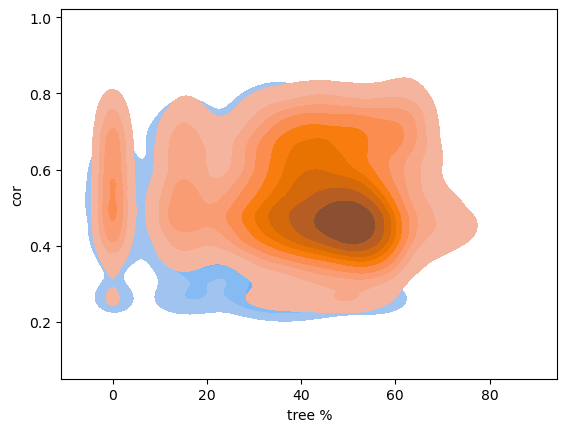

In [103]:
df = pd.DataFrame(np.vstack([decid, decid_cor]).T, columns = ['tree %', 'cor'])
sns.kdeplot(data = df.iloc[::100], x= 'tree %', y = 'cor', fill = True)
df = pd.DataFrame(np.vstack([evergre, evergre_cor]).T, columns = ['tree %', 'cor'])
sns.kdeplot(data = df.iloc[::100], x= 'tree %', y = 'cor', fill = True)


Text(0.5, 0, '')

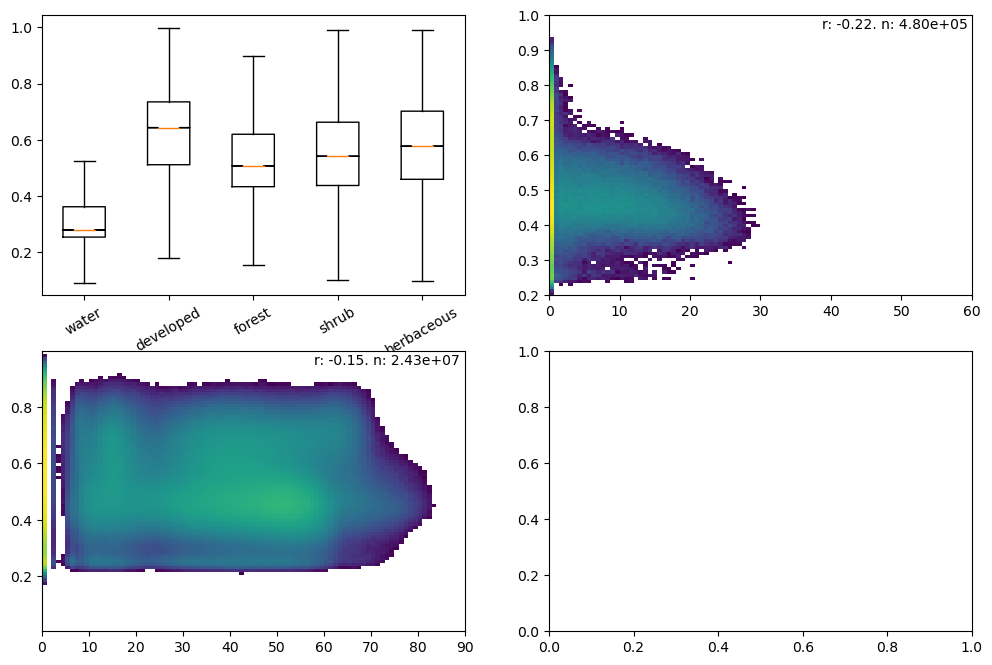

In [118]:
fig, axes= plt.subplots(2,2, figsize = (12, 8))

ax = axes.ravel()[1]
ax.hist2d(lidar_trees, lidar_taus, bins = 90, norm = mpl.colors.LogNorm(), cmin = 10, range = [[0, 60],[0.2, 1]])
rmse, r ,n = get_stats(lidar_trees, lidar_taus)
add_text(f'r: {r:.2f}. n: {n:.2e}', ax, 'upper right')

ax = axes.ravel()[2]
ax.hist2d(trees, taus, bins = 90, norm = mpl.colors.LogNorm(), cmin = 100)
rmse, r ,n = get_stats(trees, taus)
add_text(f'r: {r:.2f}. n: {n:.2e}', ax, 'upper right')

# landcover
ax = axes.ravel()[0]
ax.boxplot(lc.values(), notch = True, showfliers= False)
ax.set_xticks(np.arange(1, len(lc)+1, 1), lc.keys(), rotation = 30)
ax.set_xlabel('') # Land Cover

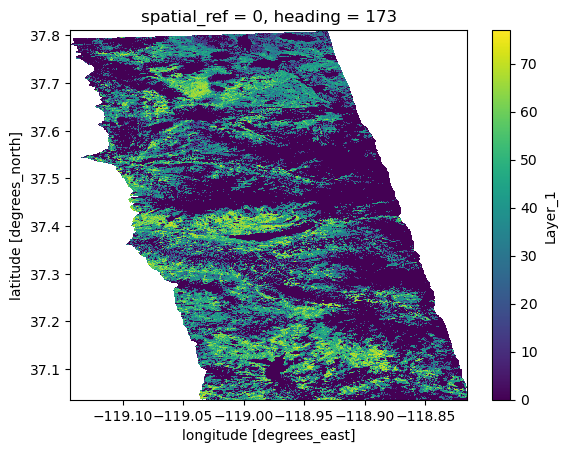

In [114]:
ds['tree_perc'].where(~ds['inc'].isel(heading = 0).isnull()).plot()

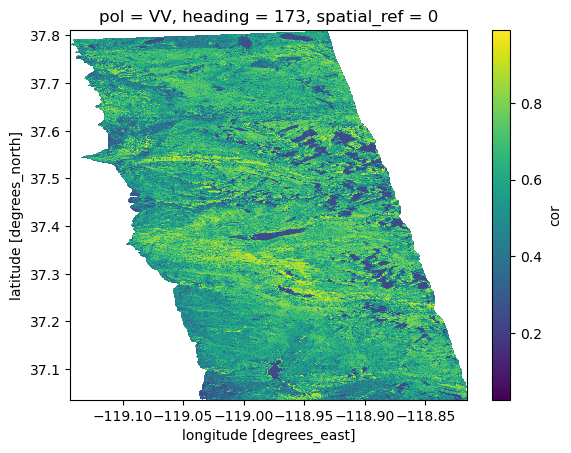

In [112]:
ds['cor'].sel(pol = 'VV').mean(['time1', 'time2']).isel(heading = 0).plot()

In [121]:
plt_lc(ds['land_cover'], plt.gca())